In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import torch
import matplotlib.pyplot as plt

### Load Data

In [2]:
data_train = pd.read_csv('Google_Stock_Price_Train.csv.xls', thousands=',')
data_train.shape

(1258, 6)

In [3]:
data_test = pd.read_csv('Google_Stock_Price_Test.csv.xls',thousands=',')
data_test

,Date,Open,High,Low,Close,Volume
0,1/3/2017,778.81,789.63,775.80,786.14,1657300
1,1/4/2017,788.36,791.34,783.16,786.90,1073000
2,1/5/2017,786.08,794.48,785.02,794.02,1335200
3,1/6/2017,795.26,807.90,792.20,806.15,1640200
4,1/9/2017,806.40,809.97,802.83,806.65,1272400
5,1/10/2017,807.86,809.13,803.51,804.79,1176800
6,1/11/2017,805.00,808.15,801.37,807.91,1065900
7,1/12/2017,807.14,807.39,799.17,806.36,1353100
8,1/13/2017,807.48,811.22,806.69,807.88,1099200
9,1/17/2017,807.08,807.14,800.37,804.61,1362100


In [4]:
data = pd.concat([data_train,data_test], axis=0 )
data

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,7380500
1,1/4/2012,331.27,333.87,329.08,666.45,5749400
2,1/5/2012,329.83,330.75,326.89,657.21,6590300
3,1/6/2012,328.34,328.77,323.68,648.24,5405900
4,1/9/2012,322.04,322.29,309.46,620.76,11688800
...,...,...,...,...,...,...
15,1/25/2017,829.62,835.77,825.06,835.67,1494500
16,1/26/2017,837.81,838.00,827.01,832.15,2973900
17,1/27/2017,834.71,841.95,820.44,823.31,2965800
18,1/30/2017,814.66,815.84,799.80,802.32,3246600


In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
data = data.iloc[:,1:]
data

,Open,High,Low,Close,Volume
0,325.25,332.83,324.97,663.59,7380500
1,331.27,333.87,329.08,666.45,5749400
2,329.83,330.75,326.89,657.21,6590300
3,328.34,328.77,323.68,648.24,5405900
4,322.04,322.29,309.46,620.76,11688800
...,...,...,...,...,...
15,829.62,835.77,825.06,835.67,1494500
16,837.81,838.00,827.01,832.15,2973900
17,834.71,841.95,820.44,823.31,2965800
18,814.66,815.84,799.80,802.32,3246600


In [6]:
data_scaled = scaler.fit_transform(data)
data_scaled.shape

(1278, 5)

In [7]:
def split_data(stock, lookback): 
    data = []

    for i in range(len(stock) - lookback): 
        data.append(stock[i: i + lookback])
    
    data = np.array(data);
    val_set_size = int(np.round(0.2*data_train.shape[0]));
    train_set_size = data_train.shape[0] - (val_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_val = data[train_set_size:,:-1]
    y_val = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_val, y_val]

In [8]:
lookback = 5
x_train, y_train, x_val, y_val = split_data(data_scaled, lookback)

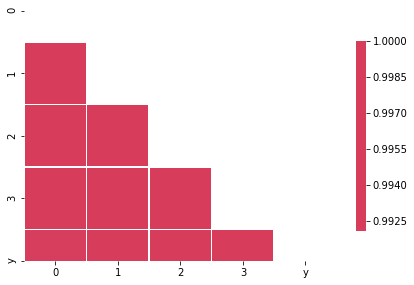

In [9]:
#create training dataframe to check correlation
df_y = pd.DataFrame(y_train[:,0],columns = ['y'])
df_x = pd.DataFrame(x_train[:,:,0])
df = pd.concat([df_x, df_y], axis=1)

corr_matrix_1 = df.corr()
f, ax = plt.subplots(figsize=(7, 7))
cmap = sns.diverging_palette(240, 5, as_cmap=True)
mask = np.triu(np.ones_like(corr_matrix_1, dtype=np.bool))
sns.heatmap(corr_matrix_1, mask= mask, cmap=cmap, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})

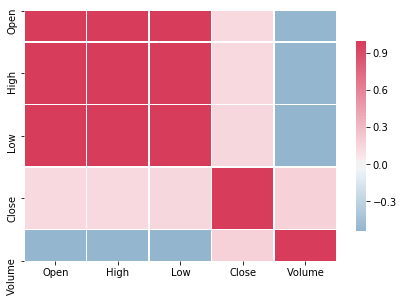

In [10]:
corr_matrix = data.corr()
f, ax = plt.subplots(figsize=(7, 7))
cmap = sns.diverging_palette(240, 5, as_cmap=True)
sns.heatmap(corr_matrix, cmap=cmap, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [11]:
import torch
import torch.nn as nn

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_val = torch.from_numpy(x_val).type(torch.Tensor)

y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_val_lstm = torch.from_numpy(y_val).type(torch.Tensor)

y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_val_gru = torch.from_numpy(y_val).type(torch.Tensor)

y_train_rnn = torch.from_numpy(y_train).type(torch.Tensor)
y_val_rnn = torch.from_numpy(y_val).type(torch.Tensor)


#### Test data preprocessing

In [12]:
lookback = 5

def split_test(stock, lookback): 
    data = []

    for i in range(len(stock) - lookback): 
        data.append(stock[i: i + lookback])
    
    data = np.array(data);
    
    x_test = data[1253:,:-1,:]
    y_test = data[1253:,-1,:]
    
    return [x_test, y_test]

x_test, y_test = split_test(data_scaled, lookback)


In [13]:
x_test = torch.from_numpy(x_test).type(torch.Tensor)

y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)
y_test_rnn = torch.from_numpy(y_test).type(torch.Tensor)

x_test.shape

torch.Size([20, 4, 5])

### LSTM

In [14]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [15]:
input_dim = 5
hidden_dim = 64
num_layers = 1
output_dim = 5
num_epochs = 200

In [16]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [17]:
import time
start_time = time.time()

hist = np.zeros(num_epochs)
lstm = []
for t in range(num_epochs):
    y_train_pred_lstm = model(x_train)
    loss = criterion(y_train_pred_lstm, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
lstm_training_time = time.time()-start_time
print("Training time: {}".format(lstm_training_time))

Epoch  0 MSE:  0.3624621033668518
Epoch  1 MSE:  0.2772362232208252
Epoch  2 MSE:  0.20286191999912262
Epoch  3 MSE:  0.13351283967494965
Epoch  4 MSE:  0.09818728268146515
Epoch  5 MSE:  0.10355151444673538
Epoch  6 MSE:  0.07698873430490494
Epoch  7 MSE:  0.06065703555941582
Epoch  8 MSE:  0.05240648239850998
Epoch  9 MSE:  0.04543498158454895
Epoch  10 MSE:  0.043810393661260605
Epoch  11 MSE:  0.042790282517671585
Epoch  12 MSE:  0.03847486898303032
Epoch  13 MSE:  0.032369788736104965
Epoch  14 MSE:  0.027160804718732834
Epoch  15 MSE:  0.02362467162311077
Epoch  16 MSE:  0.02048790268599987
Epoch  17 MSE:  0.01650337688624859
Epoch  18 MSE:  0.012930274941027164
Epoch  19 MSE:  0.012710589915513992
Epoch  20 MSE:  0.015502065420150757
Epoch  21 MSE:  0.016703840345144272
Epoch  22 MSE:  0.01550418883562088
Epoch  23 MSE:  0.01423637755215168
Epoch  24 MSE:  0.01299700140953064
Epoch  25 MSE:  0.010946600697934628
Epoch  26 MSE:  0.00904356874525547
Epoch  27 MSE:  0.0084870876744

In [18]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred_lstm.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

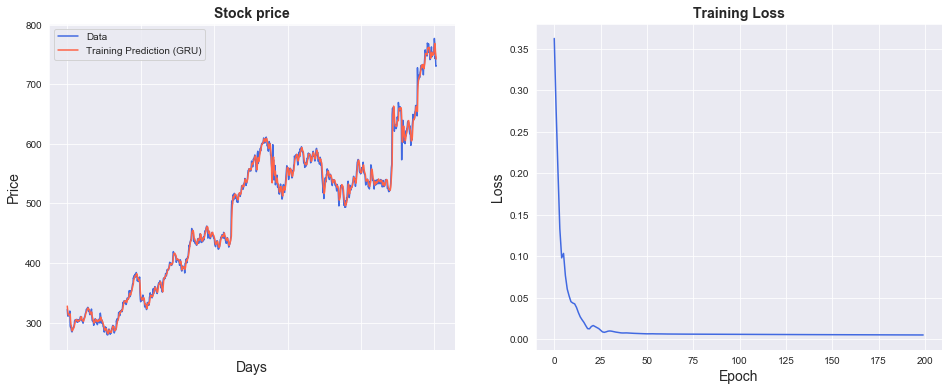

In [19]:
import seaborn as sns
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (GRU)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Price", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [20]:
# make predictions with validation set
y_val_pred_lstm = model(x_val)
y_val_pred_lstm

#invert predictions
y_train_pred_lstm = scaler.inverse_transform(y_train_pred_lstm.detach().numpy())
y_train_lstm = scaler.inverse_transform(y_train_lstm.detach().numpy())

y_val_pred_lstm = scaler.inverse_transform(y_val_pred_lstm.detach().numpy())
y_val_lstm = scaler.inverse_transform(y_val_lstm.detach().numpy())

In [21]:
# calculate root mean squared error
from sklearn.metrics import mean_squared_error
import math

lstm_train_error_list = [] 
for i in range(5):
    train_error_lstm  = math.sqrt(mean_squared_error(y_train_lstm[:,i], y_train_pred_lstm[:,i]))
    lstm_train_error_list.append(train_error_lstm)
    
lstm_val_error_list = []    
for i in range(5):
    val_error_lstm  = math.sqrt(mean_squared_error(y_val_lstm[:,i], y_val_pred_lstm[:,i]))
    lstm_val_error_list.append(val_error_lstm)

In [22]:
print(lstm_train_error_list)
print(lstm_val_error_list)

[7.810547119201671, 8.58122444788052, 8.460720633618434, 23.388059833458556, 1751295.607074945]
[9.861821906272448, 9.840978032330552, 11.352691573236333, 11.17017169052039, 780780.1912241371]


In [23]:
# make predictions with test set
y_test_pred_lstm = model(x_test)

# invert predictions
y_test_pred_lstm = scaler.inverse_transform(y_test_pred_lstm.detach().numpy())
y_test_lstm = scaler.inverse_transform(y_test_lstm.detach().numpy())

# calculate root mean squared error
lstm_test_error_list = []
for i in range(5):
    test_error_lstm  = math.sqrt(mean_squared_error(y_test_lstm[:,i], y_test_pred_lstm[:,i]))
    lstm_test_error_list.append(test_error_lstm)
    
print(lstm_test_error_list)
print(y_test_pred_lstm)

[10.293032495058778, 9.098683909728932, 10.839154327738273, 14.09621825670364, 631878.9457736347]
[[7.8455371e+02 7.9205048e+02 7.7805768e+02 7.7667462e+02 1.5950939e+06]
 [7.8067084e+02 7.8818616e+02 7.7347894e+02 7.7110773e+02 1.7227999e+06]
 [7.8044031e+02 7.8777686e+02 7.7359393e+02 7.7529718e+02 1.7881680e+06]
 [7.8257361e+02 7.9014148e+02 7.7669275e+02 7.7907153e+02 1.7181965e+06]
 [7.8499353e+02 7.9272021e+02 7.7925287e+02 7.8427478e+02 1.7292592e+06]
 [7.9101440e+02 7.9896399e+02 7.8581891e+02 7.9370251e+02 1.7393144e+06]
 [7.9710907e+02 8.0534320e+02 7.9258771e+02 7.9809711e+02 1.6801972e+06]
 [8.0010352e+02 8.0855438e+02 7.9559229e+02 7.9791327e+02 1.6436476e+06]
 [8.0110822e+02 8.0947302e+02 7.9623303e+02 7.9701123e+02 1.6203085e+06]
 [8.0127753e+02 8.0964233e+02 7.9611743e+02 7.9656494e+02 1.6369978e+06]
 [8.0257074e+02 8.1095123e+02 7.9788257e+02 7.9766492e+02 1.6081681e+06]
 [8.0171234e+02 8.1014038e+02 7.9665521e+02 7.9652472e+02 1.6380336e+06]
 [8.0119421e+02 8.0955676e

In [24]:
Error_test_pct_list_lstm = []

for i in range(5):
    Error_test_pct_lstm = abs(y_test_lstm[:,i] - y_test_pred_lstm[:,i])
    Error_test_pct_lstm = np.mean(Error_test_pct_lstm)
    Error_test_pct_lstm = Error_test_pct_lstm/(y_test_pred_lstm[:,i].mean())
    Error_test_pct_list_lstm.append(Error_test_pct_lstm)

print('LSTM test - (MAPE):', Error_test_pct_list_lstm)     

LSTM test - (MAPE): [0.010785185, 0.008872953, 0.0116327135, 0.01586229, 0.2928687]


### GRU

In [25]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [26]:
input_dim = 5
hidden_dim = 64
num_layers = 1
output_dim = 5
num_epochs = 200

In [27]:
model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [28]:
start_time = time.time()

hist = np.zeros(num_epochs)

for t in range(num_epochs):
    y_train_pred_gru = model(x_train)

    loss = criterion(y_train_pred_gru, y_train_gru)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
gru_training_time = time.time()-start_time    
print("GRU_Training time: {}".format(gru_training_time))

Epoch  0 MSE:  0.36838066577911377
Epoch  1 MSE:  0.23254872858524323
Epoch  2 MSE:  0.13191889226436615
Epoch  3 MSE:  0.07535853981971741
Epoch  4 MSE:  0.08716776967048645
Epoch  5 MSE:  0.06507670134305954
Epoch  6 MSE:  0.037988658994436264
Epoch  7 MSE:  0.03865837678313255
Epoch  8 MSE:  0.04449805989861488
Epoch  9 MSE:  0.04222790524363518
Epoch  10 MSE:  0.0342937633395195
Epoch  11 MSE:  0.024815762415528297
Epoch  12 MSE:  0.01721046306192875
Epoch  13 MSE:  0.013696329668164253
Epoch  14 MSE:  0.014048164710402489
Epoch  15 MSE:  0.01570657454431057
Epoch  16 MSE:  0.016273723915219307
Epoch  17 MSE:  0.015551363117992878
Epoch  18 MSE:  0.01441659964621067
Epoch  19 MSE:  0.013039983808994293
Epoch  20 MSE:  0.011424570344388485
Epoch  21 MSE:  0.010214848443865776
Epoch  22 MSE:  0.009929790161550045
Epoch  23 MSE:  0.01028981152921915
Epoch  24 MSE:  0.010590462014079094
Epoch  25 MSE:  0.010326404124498367
Epoch  26 MSE:  0.009454254992306232
Epoch  27 MSE:  0.00832295

In [29]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred_gru.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_gru.detach().numpy()))

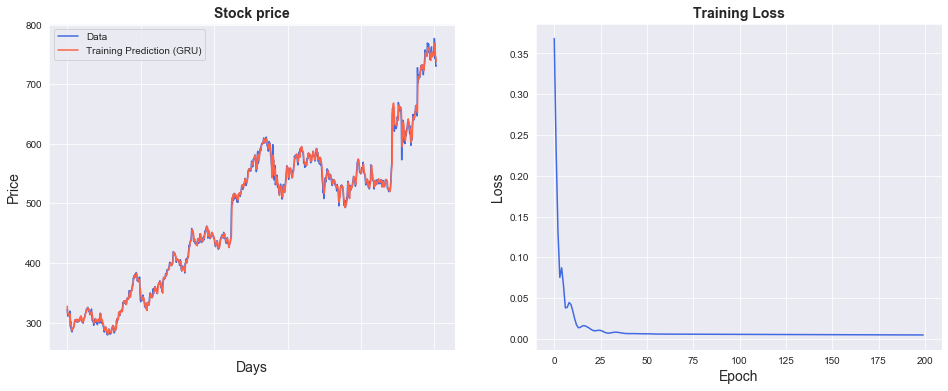

In [30]:
import seaborn as sns
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (GRU)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Price", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [31]:
# make predictions
y_val_pred_gru = model(x_val)

In [32]:
# invert predictions

y_train_pred_gru = scaler.inverse_transform(y_train_pred_gru.detach().numpy())
y_train_gru = scaler.inverse_transform(y_train_gru.detach().numpy())

y_val_pred_gru = scaler.inverse_transform(y_val_pred_gru.detach().numpy())
y_val_gru = scaler.inverse_transform(y_val_gru.detach().numpy())


In [33]:
# calculate root mean squared error
from sklearn.metrics import mean_squared_error
import math

gru_train_error_list = [] 
for i in range(5):
    train_error_gru = (np.square(y_train_gru[:,i]-y_train_pred_gru[:,i])).mean()
    train_error_gru = np.sqrt(train_error_gru)
    gru_train_error_list.append(train_error_gru)

gru_val_error_list = []    
for i in range(5):
    val_error_gru = (np.square(y_val_gru[:,i]-y_val_pred_gru[:,i])).mean()
    val_error_gru = np.sqrt(val_error_gru)
    gru_val_error_list.append(val_error_gru)


In [34]:
print(gru_train_error_list)
print(gru_val_error_list)

[7.0093174, 7.6939754, 7.834215, 22.124336, 1678606.2]
[9.423109, 9.030353, 11.721386, 9.581787, 759204.94]


In [35]:
# make predictions
y_test_pred_gru = model(x_test)

In [36]:
y_test_pred_gru = y_test_pred_gru.detach().numpy()
y_test_pred_gru = scaler.inverse_transform(y_test_pred_gru)


In [37]:
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

In [38]:
y_test_gru = y_test_gru.detach().numpy()
y_test_gru = scaler.inverse_transform(y_test_gru)


In [39]:
gru_test_error_list = []
for i in range(5):
    data_list = ['open', 'high', 'low', 'close', 'volume']
    test_error_gru = (np.square(y_test_gru[:,i]-y_test_pred_gru[:,i])).mean()
    test_error_gru = np.sqrt(test_error_gru)
    gru_test_error_list.append(test_error_gru)
    
print(gru_test_error_list)
print(y_test_pred_gru)

[12.272424, 10.392885, 14.668895, 9.651292, 690000.1]
[[7.7986255e+02 7.8753833e+02 7.7236005e+02 7.8268719e+02 1.7323155e+06]
 [7.7526270e+02 7.8316614e+02 7.6764240e+02 7.7504816e+02 1.9368944e+06]
 [7.7664716e+02 7.8438232e+02 7.6898199e+02 7.8184973e+02 2.0570315e+06]
 [7.8072931e+02 7.8806073e+02 7.7305469e+02 7.8544006e+02 1.9371980e+06]
 [7.8291699e+02 7.9056732e+02 7.7532947e+02 7.9080731e+02 1.9681641e+06]
 [7.8944037e+02 7.9733636e+02 7.8202100e+02 8.0178174e+02 2.0912118e+06]
 [7.9604041e+02 8.0370886e+02 7.8845953e+02 8.0567188e+02 2.0533352e+06]
 [7.9814447e+02 8.0584711e+02 7.9037744e+02 8.0439630e+02 2.0054736e+06]
 [7.9759174e+02 8.0536823e+02 7.8988287e+02 8.0489716e+02 1.9871076e+06]
 [7.9698962e+02 8.0483551e+02 7.8933893e+02 8.0465277e+02 2.0416756e+06]
 [7.9913464e+02 8.0690222e+02 7.9152844e+02 8.0597247e+02 2.0093015e+06]
 [7.9765149e+02 8.0552777e+02 7.8989594e+02 8.0379626e+02 2.0362254e+06]
 [7.9695886e+02 8.0477917e+02 7.8917395e+02 8.0362134e+02 2.0526565e+0

In [40]:
Error_train_pct_list = []

for i in range(5):
    Error_train_pct_gru = abs(y_train_gru[:,i] - y_train_pred_gru[:,i])
    Error_train_pct_gru = np.mean(Error_train_pct_gru)
    Error_train_pct_gru = Error_train_pct_gru/(y_train_pred_gru[:,i].mean())
    Error_train_pct_list.append(Error_train_pct_gru)
    
print('GRU Train -(MAPE):', Error_train_pct_list)        

GRU Train -(MAPE): [0.008586113, 0.009748697, 0.010592052, 0.012075082, 0.26400632]


In [41]:
Error_val_pct_list = []

for i in range(5):
    Error_val_pct_gru = abs(y_val_gru[:,i] - y_val_pred_gru[:,i])
    Error_val_pct_gru = np.mean(Error_val_pct_gru)
    Error_val_pct_gru = Error_val_pct_gru/(y_val_pred_gru[:,i].mean())
    Error_val_pct_list.append(Error_val_pct_gru)

print('GRU val - (MAPE):', Error_val_pct_list)        

GRU val - (MAPE): [0.009341453, 0.008801793, 0.012693926, 0.009392158, 0.2890474]


In [42]:
Error_test_pct_list = []

for i in range(5):
    Error_test_pct_gru = abs(y_test_gru[:,i] - y_test_pred_gru[:,i])
    Error_test_pct_gru = np.mean(Error_test_pct_gru)
    Error_test_pct_gru = Error_test_pct_gru/(y_test_pred_gru[:,i].mean())
    Error_test_pct_list.append(Error_test_pct_gru)

print('GRU test - (MAPE):', Error_test_pct_list)     

GRU test - (MAPE): [0.013786833, 0.010587426, 0.017280346, 0.009293442, 0.29500493]


### Tanh (Vanilla) RNN

In [43]:
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(RNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.RNN = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.RNN(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [44]:
input_dim = 5
hidden_dim = 64
num_layers = 1
output_dim = 5
num_epochs = 200

In [45]:
model = RNN(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [46]:
start_time = time.time()

hist = np.zeros(num_epochs)
rnn = []

for t in range(num_epochs):
    y_train_pred_rnn = model(x_train)

    loss = criterion(y_train_pred_rnn, y_train_rnn)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
rnn_training_time = time.time()-start_time    
print("Training time: {}".format(rnn_training_time))

Epoch  0 MSE:  0.36122259497642517
Epoch  1 MSE:  0.16241735219955444
Epoch  2 MSE:  0.12667347490787506
Epoch  3 MSE:  0.06014799699187279
Epoch  4 MSE:  0.04255902022123337
Epoch  5 MSE:  0.06294085830450058
Epoch  6 MSE:  0.033732615411281586
Epoch  7 MSE:  0.017307620495557785
Epoch  8 MSE:  0.02404899150133133
Epoch  9 MSE:  0.034299757331609726
Epoch  10 MSE:  0.03134245052933693
Epoch  11 MSE:  0.02536562643945217
Epoch  12 MSE:  0.021851234138011932
Epoch  13 MSE:  0.014534343965351582
Epoch  14 MSE:  0.011237416416406631
Epoch  15 MSE:  0.013976647518575191
Epoch  16 MSE:  0.01723739318549633
Epoch  17 MSE:  0.017537303268909454
Epoch  18 MSE:  0.015372443944215775
Epoch  19 MSE:  0.011651292443275452
Epoch  20 MSE:  0.009871658869087696
Epoch  21 MSE:  0.010275600478053093
Epoch  22 MSE:  0.011456751264631748
Epoch  23 MSE:  0.011028960347175598
Epoch  24 MSE:  0.009713692590594292
Epoch  25 MSE:  0.009164877235889435
Epoch  26 MSE:  0.008500680327415466
Epoch  27 MSE:  0.008

In [47]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred_rnn.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_rnn.detach().numpy()))

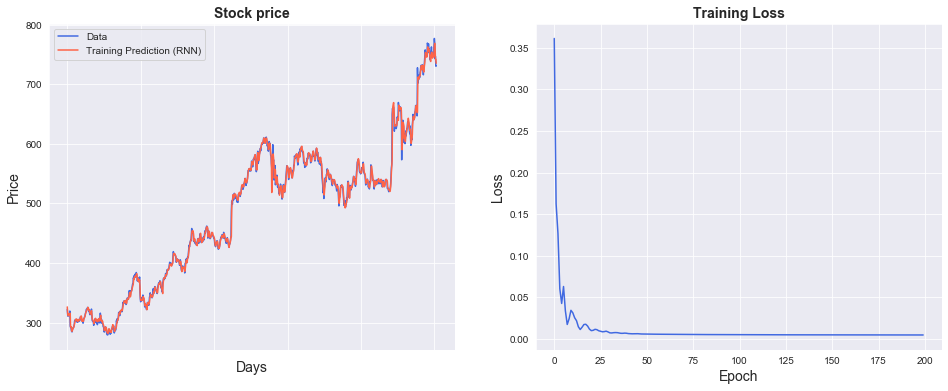

In [48]:
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (RNN)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Price", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [49]:
from sklearn.metrics import mean_squared_error

# make predictions
y_val_pred_rnn = model(x_val)

# invert predictions
y_train_pred_rnn = scaler.inverse_transform(y_train_pred_rnn.detach().numpy())
y_train_rnn = scaler.inverse_transform(y_train_rnn.detach().numpy())

y_val_pred_rnn = scaler.inverse_transform(y_val_pred_rnn.detach().numpy())
y_val_rnn = scaler.inverse_transform(y_val_rnn.detach().numpy())

rnn_train_error_list = [] 
for i in range(5):
    train_error_rnn = (np.square(y_train_rnn[:,i]-y_train_pred_rnn[:,i])).mean()
    train_error_rnn = np.sqrt(train_error_rnn)
    rnn_train_error_list.append(train_error_rnn)


rnn_val_error_list = []    
for i in range(5):
    val_error_rnn = (np.square(y_val_rnn[:,i]-y_val_pred_rnn[:,i])).mean()
    val_error_rnn = np.sqrt(val_error_rnn)
    rnn_val_error_list.append(val_error_rnn)


In [50]:
# make predictions
y_test_pred_rnn = model(x_test)

# invert predictions
y_test_pred_rnn = y_test_pred_rnn.detach().numpy()
y_test_pred_rnn = scaler.inverse_transform(y_test_pred_rnn)

y_test_rnn = y_test_rnn.detach().numpy()
y_test_rnn = scaler.inverse_transform(y_test_rnn)

rnn_test_error_list = []
for i in range(5):
    test_error_rnn = (np.square(y_test_rnn[:,i]-y_test_pred_rnn[:,i])).mean()
    test_error_rnn = np.sqrt(test_error_rnn)
    rnn_test_error_list.append(test_error_rnn)
    
print(rnn_test_error_list)
print(y_test_pred_rnn)

[11.737505, 9.8521595, 14.075024, 9.88864, 666547.9]
[[7.7743121e+02 7.8483167e+02 7.7023730e+02 7.8390448e+02 1.5715962e+06]
 [7.7330676e+02 7.8045160e+02 7.6530420e+02 7.7501337e+02 2.1262158e+06]
 [7.7582135e+02 7.8293829e+02 7.6930786e+02 7.8315076e+02 1.9827781e+06]
 [7.8053528e+02 7.8836963e+02 7.7413757e+02 7.9061511e+02 1.8643235e+06]
 [7.8259039e+02 7.9065222e+02 7.7545953e+02 7.9624554e+02 2.0160214e+06]
 [7.9094720e+02 7.9803546e+02 7.8300549e+02 8.0706543e+02 2.1505848e+06]
 [7.9718066e+02 8.0562976e+02 7.9010345e+02 8.1359821e+02 2.0141238e+06]
 [7.9832159e+02 8.0662817e+02 7.9040240e+02 8.1087317e+02 1.9648370e+06]
 [7.9712579e+02 8.0459613e+02 7.8927557e+02 8.0952759e+02 1.8772929e+06]
 [7.9657880e+02 8.0402655e+02 7.8886163e+02 8.0957623e+02 2.0442036e+06]
 [7.9889258e+02 8.0675995e+02 7.9202979e+02 8.1181360e+02 1.8945432e+06]
 [7.9700226e+02 8.0522827e+02 7.8960327e+02 8.0885022e+02 2.0784106e+06]
 [7.9645612e+02 8.0371466e+02 7.8861310e+02 8.0814935e+02 1.9369926e+06

In [51]:
Error_test_pct_list_rnn = []

for i in range(5):
    Error_test_pct_rnn = abs(y_test_rnn[:,i] - y_test_pred_rnn[:,i])
    Error_test_pct_rnn = np.mean(Error_test_pct_rnn)
    Error_test_pct_rnn = Error_test_pct_rnn/(y_test_pred_rnn[:,i].mean())
    Error_test_pct_list_rnn.append(Error_test_pct_rnn)

print('Vanilla RNN test - (MAPE):', Error_test_pct_list_rnn)     

Vanilla RNN test - (MAPE): [0.013661716, 0.010127239, 0.016627565, 0.009319216, 0.28575528]


### Model Comparison

#### Train error comparison

In [52]:
gru_train_error_list = [round(num, 3) for num in gru_train_error_list]
gru_train_error_list = pd.DataFrame(gru_train_error_list, columns=['gru'])

lstm_train_error_list = [round(num, 3) for num in lstm_train_error_list]
lstm_train_error_list = pd.DataFrame(lstm_train_error_list, columns=['lstm'])

rnn_train_error_list = [round(num, 3) for num in rnn_train_error_list]
rnn_train_error_list = pd.DataFrame(rnn_train_error_list, columns=['rnn'])

train_error = pd.concat([gru_train_error_list, lstm_train_error_list, rnn_train_error_list], axis=1)
train_error.rename({0: 'open', 1: 'high', 2:'low', 3:'close', 4:'volume'}, axis='index')

,gru,lstm,rnn
open,7.009000e+00,7.811,6.846000e+00
high,7.694000e+00,8.581,7.688000e+00
low,7.834000e+00,8.461,7.662000e+00
close,2.212400e+01,23.388,2.185900e+01
volume,1.678606e+06,1751295.607,1.653009e+06


(0, 50)

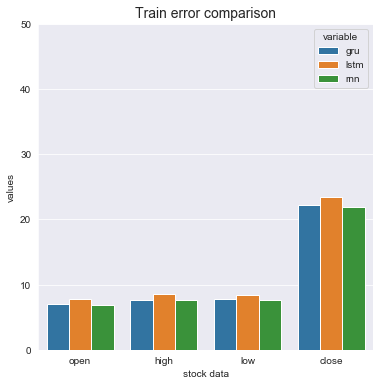

In [53]:
train_error = train_error.iloc[:4,:]
train_error.index  = ["open", "high", "low", 'close']
df_plot = train_error.reset_index().rename({'index': 'stock data'}, axis=1)
df_plot = df_plot.melt(id_vars='stock data')

fig,ax = plt.subplots(figsize=(6,6))
sns.barplot('stock data', 'value', hue='variable', data=df_plot, ax=ax)
plt.title('Train error comparison', fontsize= 14)
plt.xlabel('stock data')
plt.ylabel('values')
plt.ylim(0,50)

#### Validation error comparison

In [54]:
lstm_val_error_list = [round(num, 3) for num in lstm_val_error_list]
lstm_val_error_list = pd.DataFrame(lstm_val_error_list, columns=['lstm'])

gru_val_error_list = [round(num, 3) for num in gru_val_error_list]
gru_val_error_list = pd.DataFrame(gru_val_error_list, columns=['gru'])

rnn_val_error_list = [round(num, 3) for num in rnn_val_error_list]
rnn_val_error_list = pd.DataFrame(rnn_val_error_list, columns=['rnn'])

val_error = pd.concat([gru_val_error_list, lstm_val_error_list, rnn_val_error_list], axis=1)
val_error.rename({0: 'open', 1: 'high', 2:'low', 3:'close', 4:'volume'}, axis='index')


,gru,lstm,rnn
open,9.4230,9.862,8.989
high,9.0300,9.841,8.736
low,11.7210,11.353,11.425
close,9.5820,11.170,10.103
volume,759204.9375,780780.191,741543.125


(0, 50)

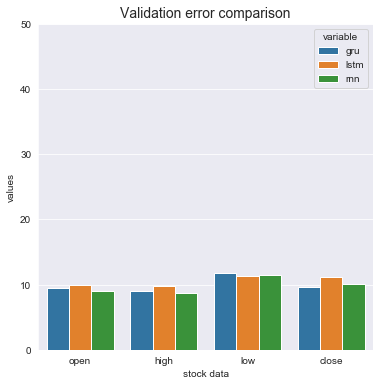

In [55]:
val_error = val_error.iloc[:4,:]
val_error.index  = ["open", "high", "low", 'close']
df_plot = val_error.reset_index().rename({'index': 'stock data'}, axis=1)
df_plot = df_plot.melt(id_vars='stock data')

fig,ax = plt.subplots(figsize=(6,6))
sns.barplot('stock data', 'value', hue='variable', data=df_plot, ax=ax)
plt.title('Validation error comparison', fontsize= 14)
plt.xlabel('stock data')
plt.ylabel('values')
plt.ylim(0,50)

#### Test error comparison


In [56]:
lstm_test_error_list = [round(num, 3) for num in lstm_test_error_list]
lstm_test_error_list = pd.DataFrame(lstm_test_error_list, columns=['lstm'])

gru_test_error_list = [round(num, 3) for num in gru_test_error_list]
gru_test_error_list = pd.DataFrame(gru_test_error_list, columns=['gru'])

rnn_test_error_list = [round(num, 3) for num in rnn_test_error_list]
rnn_test_error_list = pd.DataFrame(rnn_test_error_list, columns=['rnn'])

test_error = pd.concat([gru_test_error_list, lstm_test_error_list, rnn_test_error_list], axis=1)
test_error.rename({0: 'open', 1: 'high', 2:'low', 3:'close', 4:'volume'}, axis='index')

,gru,lstm,rnn
open,12.272,10.293,11.738
high,10.393,9.099,9.852
low,14.669,10.839,14.075
close,9.651,14.096,9.889
volume,690000.125,631878.946,666547.875


(0, 50)

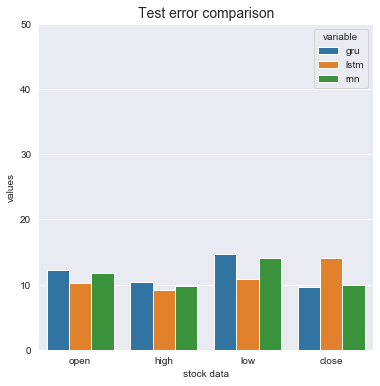

In [57]:
test_error = test_error.iloc[:4,:]
test_error.index  = ["open", "high", "low", 'close']
df_plot = test_error.reset_index().rename({'index': 'stock data'}, axis=1)
df_plot = df_plot.melt(id_vars='stock data')

fig,ax = plt.subplots(figsize=(6,6))
sns.barplot('stock data', 'value', hue='variable', data=df_plot, ax=ax)
plt.title('Test error comparison', fontsize= 14)
plt.xlabel('stock data')
plt.ylabel('values')
plt.ylim(0,50)

#### Comparision of predicted vs actual value

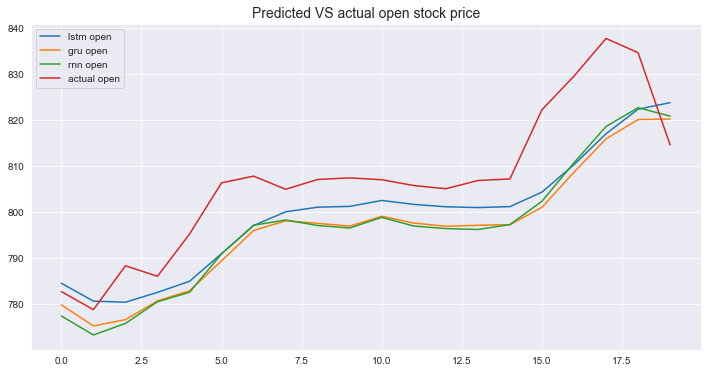

In [58]:
plt.figure(figsize=(12,6))
plt.plot(y_test_pred_lstm[:,0], label='lstm open');
plt.plot(y_test_pred_gru[:,0], label='gru open');
plt.plot(y_test_pred_rnn[:,0], label='rnn open');
plt.plot(y_test_lstm[:,0], label='actual open');
plt.title('Predicted VS actual open stock price', fontsize=14)
plt.legend()

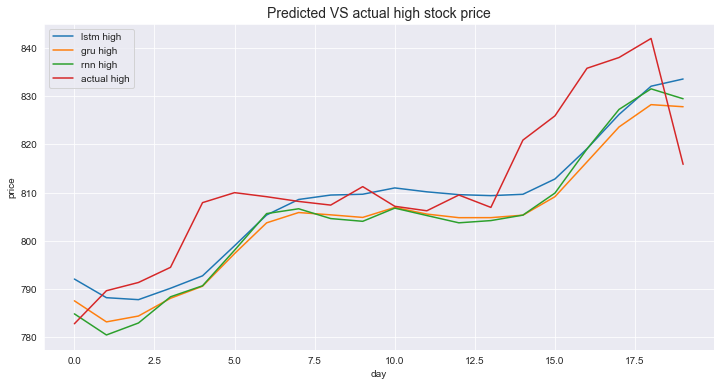

In [59]:
plt.figure(figsize=(12,6))
plt.plot(y_test_pred_lstm[:,1], label='lstm high');
plt.plot(y_test_pred_gru[:,1], label='gru high');
plt.plot(y_test_pred_rnn[:,1], label='rnn high');
plt.plot(y_test_lstm[:,1], label='actual high');
plt.title('Predicted VS actual high stock price', fontsize=14)
plt.xlabel('day')
plt.ylabel('price')
plt.legend()

In [60]:
y_test_pred_lstm.shape

(20, 5)

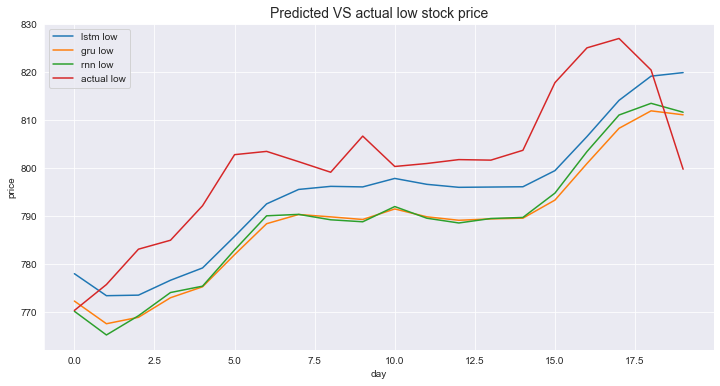

In [61]:
plt.figure(figsize=(12,6))
plt.plot(y_test_pred_lstm[:,2], label='lstm low');
plt.plot(y_test_pred_gru[:,2], label='gru low');
plt.plot(y_test_pred_rnn[:,2], label='rnn low');
plt.plot(y_test_lstm[:,2], label='actual low');
plt.title('Predicted VS actual low stock price', fontsize=14)
plt.xlabel('day')
plt.ylabel('price')
plt.legend()

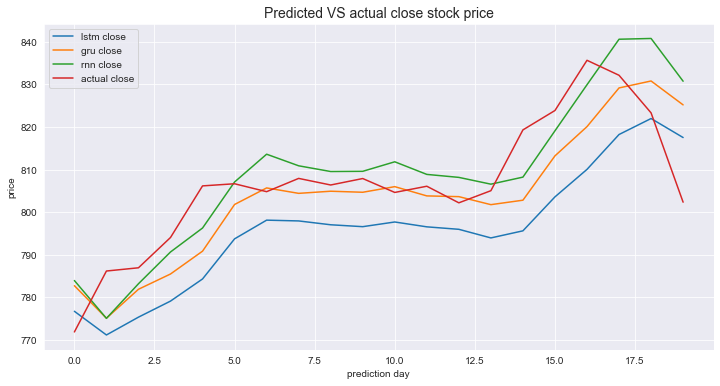

In [62]:
plt.figure(figsize=(12,6))
plt.plot(y_test_pred_lstm[:,3], label='lstm close');
plt.plot(y_test_pred_gru[:,3], label='gru close');
plt.plot(y_test_pred_rnn[:,3], label='rnn close');
plt.plot(y_test_lstm[:,3], label='actual close');
plt.title('Predicted VS actual close stock price', fontsize=14)
plt.xlabel('prediction day')
plt.ylabel('price')
plt.legend()

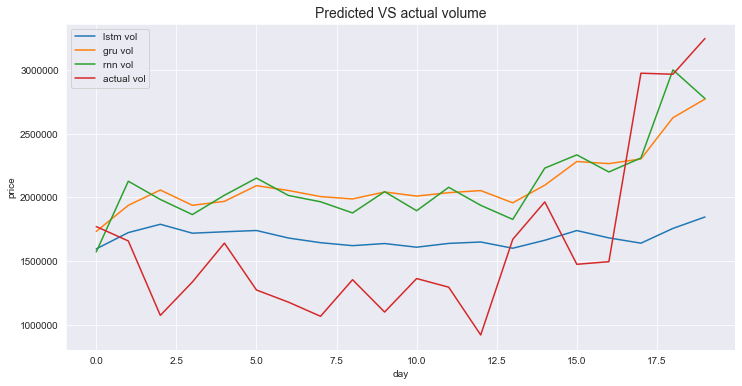

In [63]:
plt.figure(figsize=(12,6))
plt.plot(y_test_pred_lstm[:,4], label='lstm vol');
plt.plot(y_test_pred_gru[:,4], label='gru vol');
plt.plot(y_test_pred_rnn[:,4], label='rnn vol');
plt.plot(y_test_lstm[:,4], label='actual vol');
plt.title('Predicted VS actual volume', fontsize=14)
plt.xlabel('day')
plt.ylabel('price')
plt.legend()